In [6]:
#Libraries needed
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

import shap
import matplotlib.pyplot as plt

In [7]:
#HyperParamter Random selection

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
               'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
               'RF__bootstrap': bootstrap}

print(random_grid)

{'RF__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'RF__max_features': ['sqrt', 'log2', None], 'RF__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'RF__min_samples_split': [2, 5, 10], 'RF__min_samples_leaf': [1, 2, 4], 'RF__bootstrap': [True, False]}


In [8]:
#set up data for training.
df = pd.read_csv('India Agriculture Crop Production Cleaned with Geo.csv')
df = df.dropna()

X = df.drop(['Yield', 'Area Units', 'Production Units'], axis = 1)
Y = df['Yield']

#OHE
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [9]:
#Model Training/HP tuning
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('RF', RandomForestRegressor(random_state=42))
])

# Randomized search
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=random_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

# Fit the search
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score (MSE):", random_search.best_score_)
print("Best Score (RMSE):", (-random_search.best_score_)**0.5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END RF__bootstrap=True, RF__max_depth=40, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=200; total time= 3.2min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END RF__bootstrap=True, RF__max_depth=40, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=200; total time= 3.3min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END RF__bootstrap=True, RF__max_depth=40, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=200; total time= 3.3min
[CV] END RF__bootstrap=True, RF__max_depth=40, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=200; total time= 3.3min
[CV] END RF__bootstrap=True, RF__max_depth=40, RF__max_features=sqrt, RF__min_samples_leaf=2, RF__min_samples_split=10, RF__n_estimators=200; total time= 3.3min


KeyboardInterrupt: 

In [ ]:
#Random Forest Pipeline using best Parameters
pipeline3 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('RF', RandomForestRegressor(
        n_estimators=200,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features=None,
        max_depth=None,
        bootstrap=False))
])

# Train model
pipeline3.fit(X_train, y_train)

# Predict and evaluate
y_pred3 = pipeline3.predict(X_test)
mse3 = mean_squared_error(y_test, y_pred3)
print("\nMean Squared Error:", mse3)
print("\nRoot Mean Squared Error:", mse3**0.5)


Mean Squared Error of Random Forest: 72730.26673637527

Root Mean Squared Error: 269.6854959696114


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


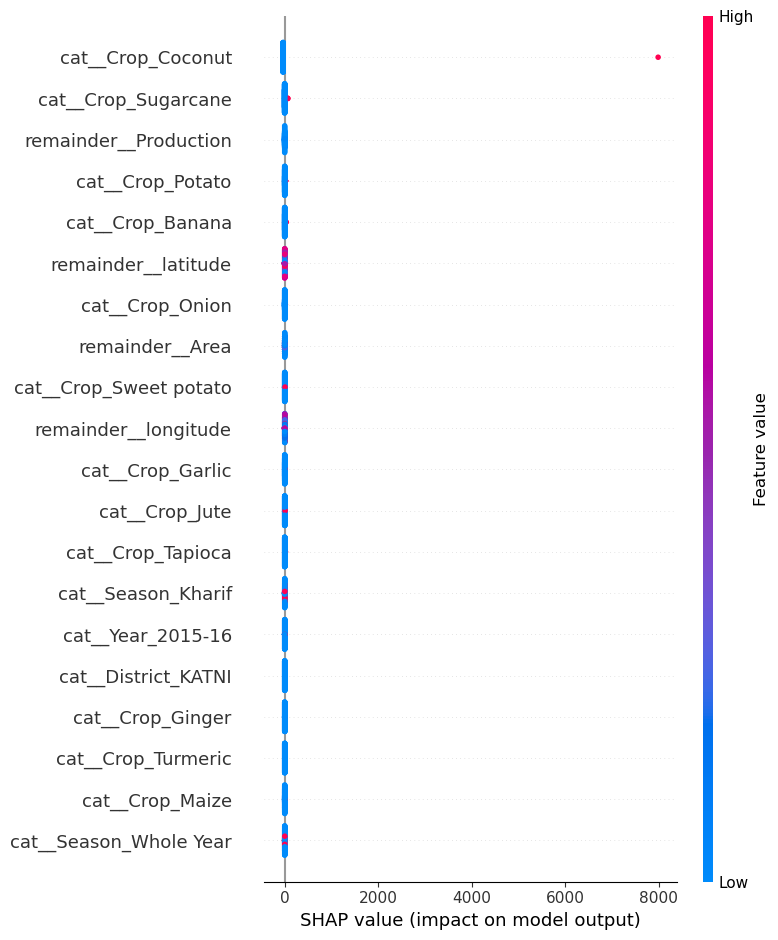

In [ ]:
#SHAP Analysis
best_model = random_search.best_estimator_

# Convert the transformed data to a dense numeric array
X_train_transformed = best_model['preprocessor'].transform(X_train)
X_test_transformed = best_model['preprocessor'].transform(X_test)

# Convert to dense numeric array (handle sparse matrix case)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

# Convert to float to avoid dtype issues
X_train_transformed = X_train_transformed.astype(float)
X_test_transformed = X_test_transformed.astype(float)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model['RF'])
shap_values = explainer.shap_values(X_test_transformed)

# Feature names (after encoding)
encoded_feature_names = best_model['preprocessor'].get_feature_names_out()

# Convert to DataFrame for better readability
shap_df = pd.DataFrame(shap_values, columns=encoded_feature_names)

# 🔹 1. Global Feature Importance (Summary Plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_transformed, feature_names=encoded_feature_names)

# 🔹 2. Single Instance Analysis (Force Plot)
# Note: Force plots are interactive in Jupyter Notebooks, but can also be saved as HTML.
instance_index = 0  # Adjust this index as needed
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[instance_index], 
                X_test_transformed[instance_index], feature_names=encoded_feature_names)

# 🔹 3. Dependency Plot (Feature Interactions)
#shap.dependence_plot("cat__Irrigation_Type_Manual", shap_values, X_test_transformed, feature_names=encoded_feature_names)